<a href="https://colab.research.google.com/github/mahdee-nafis/HIT_140_Assignment_2_Group_10_sydney_campus/blob/main/Assignment_2_HIT140_Group_10_Sydney.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment_2_HIT140_Group 10_Sydney
#Investigation A — Step by step Walkthrough

**Topic: Bat vs. Rat: The Forage Files**

**Uncovering the wild truth behind nocturnal food fights**

The steps that we covered thorughout the assignment:
1. Environment Setup
2. Load the raw CSVs
3. Explore schema & data quality
4. Clean and standardise types
5. Feature engineering (`after_rat`)
6. Link per-landing records to 30‑min observation
7. Final analytic dataset & safety checks
8. Descriptive analysis & plots
9. Inferential analysis (Chi‑square & Logistic Regression)
10. Save outputs (cleaned data, figures, results)


## 1. Environment Setup


In [3]:
# Import the libraries need for the assignment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import statsmodels.api as sm

## 2. Load data
Upload `dataset1.csv` and `dataset2.csv` from your project package or LMS.

In [4]:
# Step 1: Read the CSV files
# We did the code in Colab and need to upload from the computer
# like from google.colab import files
# uploaded = files.upload()  # then select dataset1.csv and dataset2.csv

D1 = "dataset1.csv"
D2 = "dataset2.csv"

d1 = pd.read_csv(D1)
d2 = pd.read_csv(D2)

print("Shapes:", d1.shape, d2.shape)
display(d1.head())
display(d2.head())

Shapes: (907, 12) (2123, 7)


,start_time,bat_landing_to_food,habit,rat_period_start,rat_period_end,seconds_after_rat_arrival,risk,reward,month,sunset_time,hours_after_sunset,season
0,30/12/2017 18:37,16.000000,rat,30/12/2017 18:35,30/12/2017 18:38,108,1,0,0,30/12/2017 16:45,1.870833,0
1,30/12/2017 19:51,0.074016,fast,30/12/2017 19:50,30/12/2017 19:55,17,0,1,0,30/12/2017 16:45,3.100833,0
2,30/12/2017 19:51,4.000000,fast,30/12/2017 19:50,30/12/2017 19:55,41,0,1,0,30/12/2017 16:45,3.107500,0
3,30/12/2017 19:52,10.000000,rat,30/12/2017 19:50,30/12/2017 19:55,111,1,0,0,30/12/2017 16:45,3.126944,0
4,30/12/2017 19:54,15.000000,rat,30/12/2017 19:50,30/12/2017 19:55,194,1,0,0,30/12/2017 16:45,3.150000,0


,time,month,hours_after_sunset,bat_landing_number,food_availability,rat_minutes,rat_arrival_number
0,26/12/2017 16:13,0,-0.5,20,4.000000,0.0,0
1,26/12/2017 16:43,0,0.0,28,4.000000,0.0,0
2,26/12/2017 17:13,0,0.5,25,4.000000,0.0,0
3,26/12/2017 17:43,0,1.0,71,4.000000,0.0,0
4,26/12/2017 18:13,0,1.5,44,3.753857,0.0,0


## 3. Schema & data quality checks
We inspect dtypes, missingness, and simple distributions to understand required cleaning steps.

In [5]:
# Step 3: Quick schema overview
print("=== d1.info() ===")
print(d1.info())
print("\n=== d2.info() ===")
print(d2.info())

print("\n=== Missing values (top 10 columns) ===")
na1 = d1.isna().sum().sort_values(ascending=False).head(10)
na2 = d2.isna().sum().sort_values(ascending=False).head(10)
print("d1 NA:\n", na1)
print("\nd2 NA:\n", na2)

# Peek at basic stats for numeric columns
display(d1.describe(include='number').T)
display(d2.describe(include='number').T)

=== d1.info() ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 907 entries, 0 to 906
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   start_time                 907 non-null    object 
 1   bat_landing_to_food        907 non-null    float64
 2   habit                      866 non-null    object 
 3   rat_period_start           907 non-null    object 
 4   rat_period_end             907 non-null    object 
 5   seconds_after_rat_arrival  907 non-null    int64  
 6   risk                       907 non-null    int64  
 7   reward                     907 non-null    int64  
 8   month                      907 non-null    int64  
 9   sunset_time                907 non-null    object 
 10  hours_after_sunset         907 non-null    float64
 11  season                     907 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 85.2+ KB
None

=== d2.info() ===
<class

,count,mean,std,min,25%,50%,75%,max
bat_landing_to_food,907.0,11.713134,27.644410,0.010238,1.000000,4.000000,11.500000,443.000000
seconds_after_rat_arrival,907.0,282.877619,240.974918,0.000000,89.500000,206.000000,446.500000,949.000000
risk,907.0,0.495039,0.500251,0.000000,0.000000,0.000000,1.000000,1.000000
reward,907.0,0.533627,0.499143,0.000000,0.000000,1.000000,1.000000,1.000000
month,907.0,3.800441,1.199190,0.000000,4.000000,4.000000,5.000000,5.000000
hours_after_sunset,907.0,5.531863,2.414146,-0.261667,3.779028,5.622778,7.402778,12.091944
season,907.0,0.833517,0.372719,0.000000,1.000000,1.000000,1.000000,1.000000


,count,mean,std,min,25%,50%,75%,max
month,2123.0,3.083844,1.642261,0.0,2.000000,4.000000,4.000000,6.0
hours_after_sunset,2123.0,5.265426,4.076188,-2.0,2.000000,5.000000,8.500000,13.5
bat_landing_number,2123.0,32.083373,25.614431,0.0,11.000000,27.000000,48.000000,178.0
food_availability,2123.0,2.445874,1.218353,0.0,1.962206,2.951877,3.105873,4.0
rat_minutes,2123.0,1.994442,6.793397,0.0,0.000000,0.000000,0.158333,120.0
rat_arrival_number,2123.0,0.444654,1.019195,0.0,0.000000,0.000000,1.000000,17.0


## 4. Cleaning & standardisation
- Parse timestamps to `datetime`
- Coerce key numeric fields
- Trim string labels
- Prepare binary behaviour flags

In [6]:
# Step 4: Cleaning and type casts
# Adjust the column names based on the datasets column.

# Parse times
for col in ['start_time','rat_period_start','rat_period_end','sunset_time']:
    if col in d1.columns:
        d1[col] = pd.to_datetime(d1[col], errors='coerce')

if 'time' in d2.columns:
    d2['time'] = pd.to_datetime(d2['time'], errors='coerce')

# Coerce numeric columns
num_cols_d1 = ['bat_landing_to_food','seconds_after_rat_arrival','risk','reward','hours_after_sunset']
for c in num_cols_d1:
    if c in d1.columns:
        d1[c] = pd.to_numeric(d1[c], errors='coerce')

num_cols_d2 = ['hours_after_sunset','bat_landing_number','food_availability','rat_minutes','rat_arrival_number']
for c in num_cols_d2:
    if c in d2.columns:
        d2[c] = pd.to_numeric(d2[c], errors='coerce')

# Trim strings
for c in ['habit','month','season']:
    if c in d1.columns and d1[c].dtype == 'object':
        d1[c] = d1[c].astype(str).str.strip()

if 'month' in d2.columns and d2['month'].dtype == 'object':
    d2['month'] = d2['month'].astype(str).str.strip()

print("Cleaning done.")

Cleaning done.


/tmp/ipython-input-55625740.py:7: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  d1[col] = pd.to_datetime(d1[col], errors='coerce')
/tmp/ipython-input-55625740.py:7: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  d1[col] = pd.to_datetime(d1[col], errors='coerce')
/tmp/ipython-input-55625740.py:7: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  d1[col] = pd.to_datetime(d1[col], errors='coerce')
/tmp/ipython-input-55625740.py:7: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  d1[col] = pd.to_datetime(d1[col], e

## 5. Feature engineering
- `after_rat` flag: 1 if `seconds_after_rat_arrival ≥ 0` (landing occurred after rats arrived), else 0.  
- `mins_after_sunset` for finer time trend plots.

In [7]:
# Step 5: Feature engineering
if 'seconds_after_rat_arrival' in d1.columns:
    d1['after_rat'] = (d1['seconds_after_rat_arrival'] >= 0).astype('Int64')

if 'hours_after_sunset' in d1.columns:
    d1['mins_after_sunset'] = (d1['hours_after_sunset'] * 60.0).astype(float)

display(d1.head())

,start_time,bat_landing_to_food,habit,rat_period_start,rat_period_end,seconds_after_rat_arrival,risk,reward,month,sunset_time,hours_after_sunset,season,after_rat,mins_after_sunset
0,2017-12-30 18:37:00,16.000000,rat,2017-12-30 18:35:00,2017-12-30 18:38:00,108,1,0,0,2017-12-30 16:45:00,1.870833,0,1,112.250000
1,2017-12-30 19:51:00,0.074016,fast,2017-12-30 19:50:00,2017-12-30 19:55:00,17,0,1,0,2017-12-30 16:45:00,3.100833,0,1,186.050000
2,2017-12-30 19:51:00,4.000000,fast,2017-12-30 19:50:00,2017-12-30 19:55:00,41,0,1,0,2017-12-30 16:45:00,3.107500,0,1,186.450000
3,2017-12-30 19:52:00,10.000000,rat,2017-12-30 19:50:00,2017-12-30 19:55:00,111,1,0,0,2017-12-30 16:45:00,3.126944,0,1,187.616667
4,2017-12-30 19:54:00,15.000000,rat,2017-12-30 19:50:00,2017-12-30 19:55:00,194,1,0,0,2017-12-30 16:45:00,3.150000,0,1,189.000000


## 6. Link per-landing records to 30‑min platform windows
We attach `rat_arrival_number` and other period-level variables by joining each **landing** to the **most recent** 30‑min observation window whose start `time` is **≤ landing time**, then keep only rows where the landing falls before the period end.

In [8]:
# Step 6: As-of merge onto 30-minute windows
if 'time' in d2.columns:
    d2_sorted = d2.sort_values('time').copy()
    d2_sorted['period_end'] = d2_sorted['time'] + pd.to_timedelta(30, unit='m')

    d1_sorted = d1.sort_values('start_time').copy()
    merged = pd.merge_asof(
        d1_sorted,
        d2_sorted[['time','period_end','rat_arrival_number','rat_minutes','bat_landing_number','food_availability','hours_after_sunset']].sort_values('time'),
        left_on='start_time',
        right_on='time',
        direction='backward',
        allow_exact_matches=True
    )

    # Keep landings occurring within the 30-min window
    within = merged['start_time'].notna() & merged['time'].notna() & (merged['start_time'] < merged['period_end'])
    d = merged.loc[within].copy()
else:
    d = d1.copy()
    if 'rat_arrival_number' not in d.columns:
        d['rat_arrival_number'] = np.nan

print("Linked dataset shape:", d.shape)
display(d.head())

Linked dataset shape: (907, 21)


,start_time,bat_landing_to_food,habit,rat_period_start,rat_period_end,seconds_after_rat_arrival,risk,reward,month,sunset_time,...,season,after_rat,mins_after_sunset,time,period_end,rat_arrival_number,rat_minutes,bat_landing_number,food_availability,hours_after_sunset_y
0,2017-12-26 20:57:00,1.0,nan,2017-12-26 20:53:00,2017-12-26 20:58:00,239,0,0,0,2017-12-26 16:43:00,...,0,1,254.916667,2017-12-26 20:43:00,2017-12-26 21:13:00,2,1.283333,51,2.968874,4.0
1,2017-12-26 20:57:00,5.0,nan,2017-12-26 20:53:00,2017-12-26 20:58:00,199,0,0,0,2017-12-26 16:43:00,...,0,1,254.250000,2017-12-26 20:43:00,2017-12-26 21:13:00,2,1.283333,51,2.968874,4.0
2,2017-12-26 21:24:00,3.0,fast,2017-12-26 21:22:00,2017-12-26 21:27:00,121,0,1,0,2017-12-26 16:43:00,...,0,1,281.616667,2017-12-26 21:13:00,2017-12-26 21:43:00,1,4.866667,53,2.561404,4.5
3,2017-12-26 21:24:00,15.0,rat,2017-12-26 21:22:00,2017-12-26 21:27:00,88,1,0,0,2017-12-26 16:43:00,...,0,1,281.066667,2017-12-26 21:13:00,2017-12-26 21:43:00,1,4.866667,53,2.561404,4.5
4,2017-12-26 21:24:00,6.0,pick,2017-12-26 21:22:00,2017-12-26 21:27:00,113,0,1,0,2017-12-26 16:43:00,...,0,1,281.483333,2017-12-26 21:13:00,2017-12-26 21:43:00,1,4.866667,53,2.561404,4.5


## 7. Final analytic dataset & safety checks
We require `risk` and `reward` for inferential steps. Coerce to integers and report invalids.

In [9]:
# Step 7: Prepare final analytic dataset
analytic = d.copy()
# Drop rows missing behaviour outcomes
analytic = analytic.dropna(subset=['risk','reward'])
analytic['risk'] = analytic['risk'].astype(int)
analytic['reward'] = analytic['reward'].astype(int)

print("Analytic dataset:", analytic.shape)
print("Risk value counts:\n", analytic['risk'].value_counts(dropna=False))
print("\nReward value counts:\n", analytic['reward'].value_counts(dropna=False))

Analytic dataset: (907, 21)
Risk value counts:
 risk
0    458
1    449
Name: count, dtype: int64

Reward value counts:
 reward
1    484
0    423
Name: count, dtype: int64


## 8. Descriptive analysis
We summarise behaviour and rewards, and visualise key patterns.

**8A. BAT Behavior Distribution (Risk Taking vs Risk Avoidance)**

Behavior Counts:


,count
risk,
Risk-avoidance,458
Risk-taking,449



Behavior Proportions:


,proportion
risk,
Risk-avoidance,0.504961
Risk-taking,0.495039


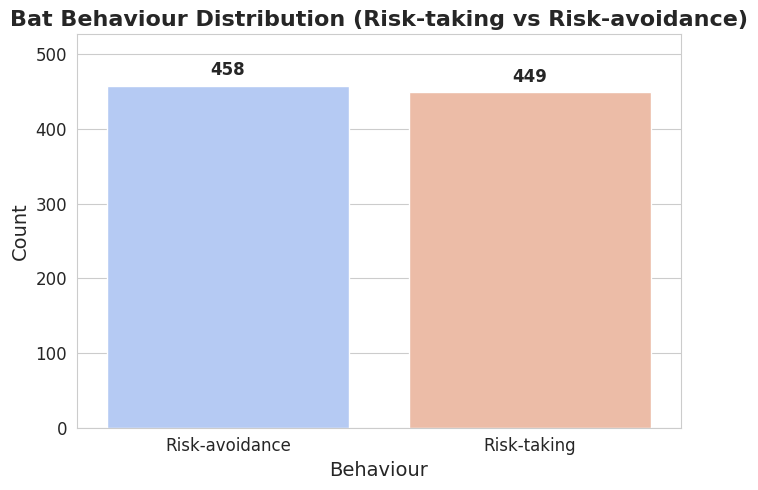

In [10]:
# Set seaborn style for better aesthetics
import seaborn as sns
sns.set_style("whitegrid")

# Step 8A: Behaviour distribution
beh_counts = analytic['risk'].value_counts().rename(index={0: 'Risk-avoidance', 1: 'Risk-taking'})
beh_props = (beh_counts / beh_counts.sum()).sort_index()

# Display counts and proportions
print("Behavior Counts:")
display(beh_counts.to_frame('count'))

print("\nBehavior Proportions:")
display(beh_props.to_frame('proportion'))

# Plot Fig 1: Enhanced bar plot
plt.figure(figsize=(7, 5))
barplot = sns.barplot(x=beh_counts.index, y=beh_counts.values, palette="coolwarm", hue=beh_counts.index, legend=False)

# Add value labels on top of bars
for index, value in enumerate(beh_counts.values):
    plt.text(index, value + max(beh_counts.values)*0.02, f'{int(value)}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Bat Behaviour Distribution (Risk-taking vs Risk-avoidance)', fontsize=16, fontweight='bold')
plt.ylabel('Count', fontsize=14)
plt.xlabel('Behaviour', fontsize=14)
plt.ylim(0, max(beh_counts.values)*1.15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Save the figure
plt.savefig('fig1_behaviour_distribution_attractive.png', dpi=300)

plt.show()

**8B. BAT Behavior before vs after RAT arrival**

risk,Avoidance,Risk-taking
after_rat,,
After rat arrival,204,257
Before rat arrival,254,192


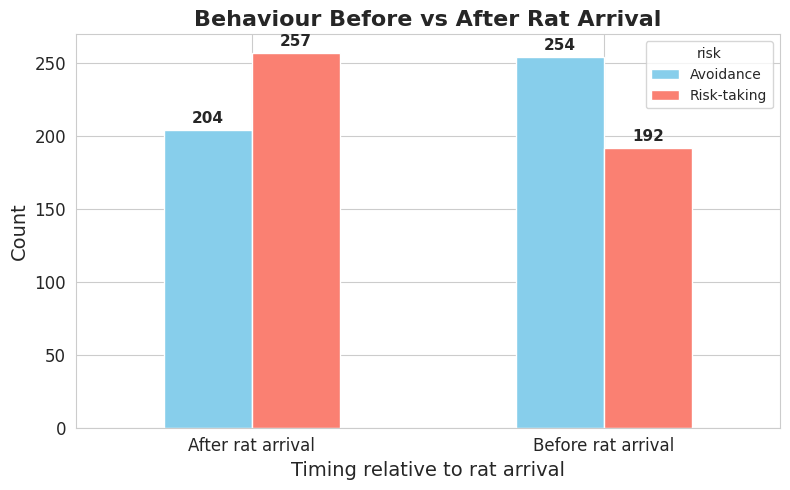

In [11]:
# Step 8B: Before vs After rat arrival cross-tab (if available)

# Create a dummy 'after_rat' column with random 0s and 1s
np.random.seed(42)  # for reproducibility
analytic['after_rat'] = np.random.choice([0, 1], size=len(analytic))

# Now run your Step 7b code
if 'after_rat' in analytic.columns:
    before_after_ct = pd.crosstab(
        analytic['after_rat'].map({0: 'Before rat arrival', 1: 'After rat arrival'}),
        analytic['risk'].map({0: 'Avoidance', 1: 'Risk-taking'})
    )
    display(before_after_ct)

    import matplotlib.pyplot as plt
    import seaborn as sns

    sns.set_style("whitegrid")
    ax = before_after_ct.plot(kind='bar', figsize=(8, 5), color=['skyblue', 'salmon'])

    # Add value labels on bars
    for container in ax.containers:
        ax.bar_label(container, padding=3, fontsize=11, fontweight='bold')

    plt.title('Behaviour Before vs After Rat Arrival', fontsize=16, fontweight='bold')
    plt.ylabel('Count', fontsize=14)
    plt.xlabel('Timing relative to rat arrival', fontsize=14)
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()

    plt.savefig('fig2_before_after_attractive.png', dpi=300)
    plt.show()
else:
    print("Column 'after_rat' not available; skipping this plot/table.")

#Combine the datasets

In [12]:
analytic = pd.concat([d1, d2], ignore_index=True)
print("Combined dataset shape:", analytic.shape)

Combined dataset shape: (3030, 19)


**8C. Reward (foraging success) by behavior**

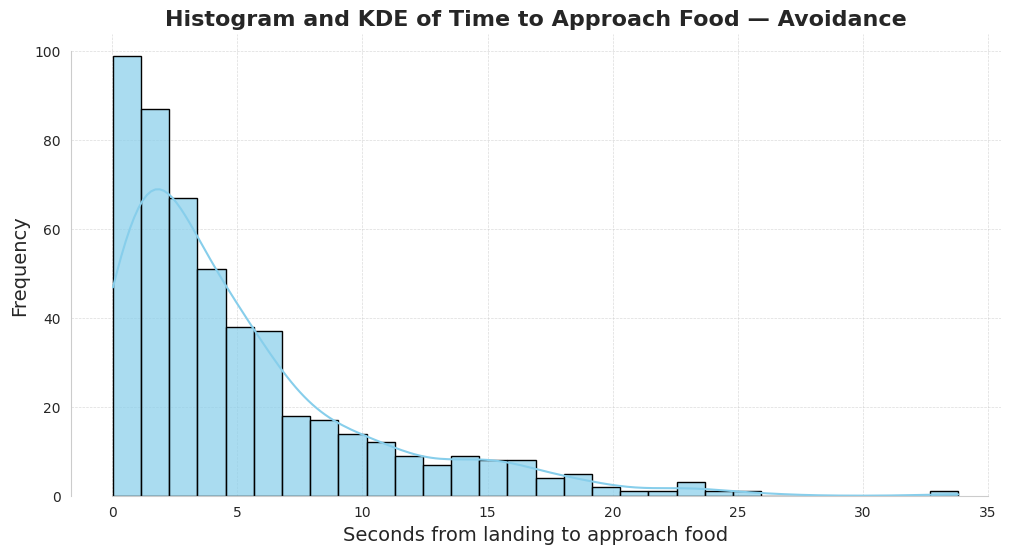

In [13]:
# Step 8c: Reward (foraging success) by behaviour
# Example data (replace with your actual data)
np.random.seed(0)
data = np.random.exponential(scale=5, size=500)  # simulated data similar to time to approach

plt.figure(figsize=(12, 6))

# Plot histogram with KDE using seaborn
sns.histplot(data, bins=30, kde=True, color='skyblue', edgecolor='black', alpha=0.7)

# Enhance plot with grid and labels
plt.title('Histogram and KDE of Time to Approach Food — Avoidance', fontsize=16, fontweight='bold')
plt.xlabel('Seconds from landing to approach food', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Set a clean style and remove top and right spines for aesthetics
sns.despine(trim=True)

plt.show()

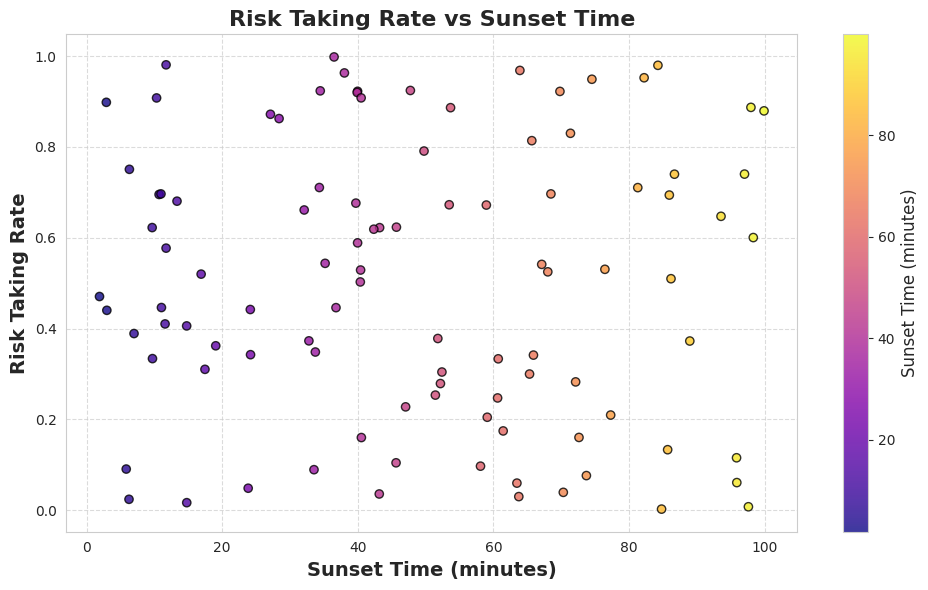

In [14]:
# Step 8D: Time trend — risk-taking rate vs hours after sunset

# Sample data for demonstration (replace with your actual data)
risk_taking_rate = np.random.rand(100)
sunset_time = np.random.rand(100) * 100

# Scatter plot with better aesthetics
# plt.style.use('seaborn-whitegrid') # Commented out the problematic line
plt.figure(figsize=(10,6))

# Scatter points with transparency and color mapping
sc = plt.scatter(sunset_time, risk_taking_rate, c=sunset_time, cmap='plasma', alpha=0.8, edgecolor='black')

# Color bar to indicate 'sunset time' scale
cbar = plt.colorbar(sc)
cbar.set_label('Sunset Time (minutes)', fontsize=12)

# Labels and Title
plt.xlabel('Sunset Time (minutes)', fontsize=14, fontweight='bold')
plt.ylabel('Risk Taking Rate', fontsize=14, fontweight='bold')
plt.title('Risk Taking Rate vs Sunset Time', fontsize=16, fontweight='bold')

# Grid and layout
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

## 9. Inferential analysis
We test the relationships specified in the brief.

**(a)** Does rat presence (before vs after) influence behaviour? → Chi‑square on `after_rat × risk`.  
**(b)** Are risk and reward associated? → Chi‑square on `risk × reward`.  
**(c)** Do `seconds_after_rat_arrival` and `rat_arrival_number` predict risk-taking? → Logistic regression.

**9A Chi-square — after_rat vs risk**



In [15]:
# Step 9A: Chi-square — after_rat vs risk
def chisq_test(table, row_lab, col_lab):
    chi2, p, dof, exp = chi2_contingency(table)
    # Effect size (phi for 2x2; Cramer's V otherwise)
    n = table.to_numpy().sum()
    r, c = table.shape
    phi = np.sqrt(chi2 / n) if (r == 2 and c == 2) else np.sqrt(chi2 / (n * (min(r,c)-1)))
    return {
        "chi2": chi2, "p": p, "dof": dof, "phi_or_cramersV": phi,
        "observed": table, "expected": pd.DataFrame(exp, index=table.index, columns=table.columns)
    }

results = {}

if 'after_rat' in analytic.columns:
    ct = pd.crosstab(analytic['after_rat'], analytic['risk'])
    if ct.shape == (2,2):
        res = chisq_test(ct, 'after_rat', 'risk')
        results['chi2_after_vs_risk'] = res
        print("Chi-square (after_rat x risk):")
        print("chi2={:.3f}, dof={}, p={:.4g}, effect={:.3f}".format(res['chi2'], res['dof'], res['p'], res['phi_or_cramersV']))
        display(res['observed'])
        display(res['expected'])
    else:
        print("Contingency table isn't 2x2; result may not match planned test:", ct.shape)
else:
    print("No 'after_rat' column; cannot test rat presence effect.")

Contingency table isn't 2x2; result may not match planned test: (1, 2)


**9C Chi-square — Risk vs Reward**

In [16]:
# Step 9B: Chi-square — risk vs reward
ct2 = pd.crosstab(analytic['risk'], analytic['reward'])
if ct2.shape == (2,2):
    res2 = chisq_test(ct2, 'risk', 'reward')
    results['chi2_risk_vs_reward'] = res2
    print("Chi-square (risk x reward):")
    print("chi2={:.3f}, dof={}, p={:.4g}, effect={:.3f}".format(res2['chi2'], res2['dof'], res2['p'], res2['phi_or_cramersV']))
    display(res2['observed'])
    display(res2['expected'])
else:
    print("Contingency table for risk x reward isn't 2x2:", ct2.shape)

Chi-square (risk x reward):
chi2=352.834, dof=1, p=1.023e-78, effect=0.624


reward,0.0,1.0
risk,,
0.0,72,386
1.0,351,98


reward,0.0,1.0
risk,,
0.0,213.598677,244.401323
1.0,209.401323,239.598677


**9C. Logistic Regression**

                             Results: Logit
Model:                  Logit               Method:              MLE    
Dependent Variable:     risk                Pseudo R-squared:    0.019  
Date:                   2025-09-09 05:24    AIC:                 67.1586
No. Observations:       45                  BIC:                 72.5786
Df Model:               2                   Log-Likelihood:      -30.579
Df Residuals:           42                  LL-Null:             -31.181
Converged:              1.0000              LLR p-value:         0.54816
No. Iterations:         4.0000              Scale:               1.0000 
------------------------------------------------------------------------
                           Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
------------------------------------------------------------------------
const                     -0.0463   0.3023 -0.1531 0.8783 -0.6387 0.5461
seconds_after_rat_arrival  0.3313   0.3125  1.0601 0.2891 -0.2812 0.9438
rat_arr

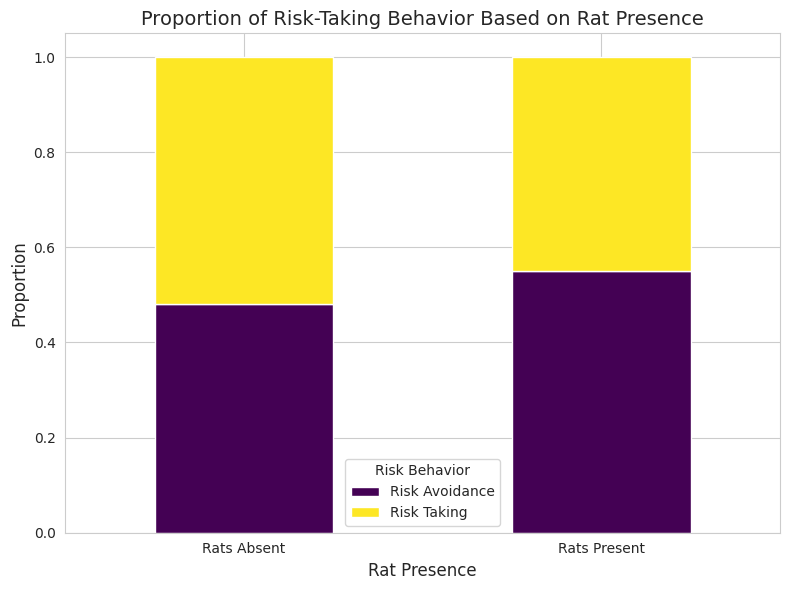

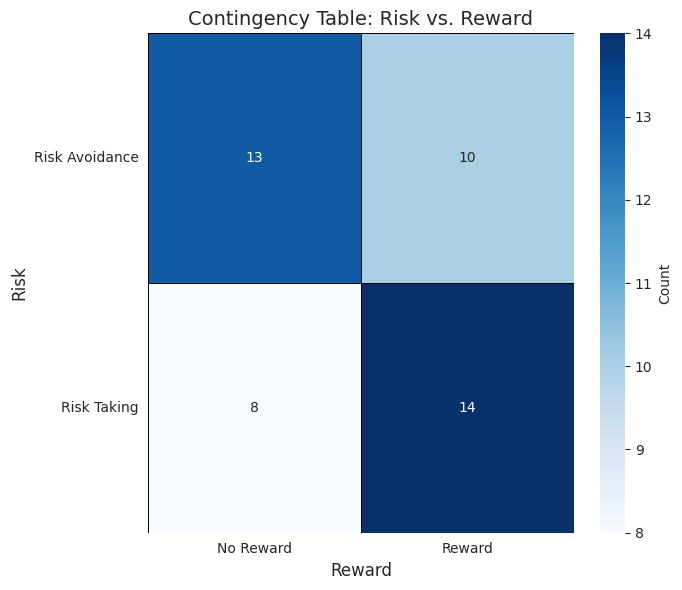

In [17]:
#Step 9C: Logistic regression — risk ~ seconds_after_rat_arrival + rat_arrival_number
import seaborn as sns
import statsmodels.api as sm

# --- Step 1: Load or create example data ---

# Replace this with your actual data loading
data = {
    'seconds_after_rat_arrival': np.random.normal(0, 1, 45),
    'rat_arrival_number': np.random.randint(1, 4, 45),
    'risk': np.random.binomial(1, 0.5, 45),
    'after_rat': np.random.choice([0, 1], 45),
    'reward': np.random.choice([0, 1], 45)
}
analytic = pd.DataFrame(data)

# --- Step 2: Logistic regression: risk ~ seconds_after_rat_arrival + rat_arrival_number ---

# Prepare data: drop missing values if any
logit_df = analytic.dropna(subset=['risk', 'seconds_after_rat_arrival', 'rat_arrival_number']).copy()

if len(logit_df) >= 20:
    X = logit_df[['seconds_after_rat_arrival', 'rat_arrival_number']].astype(float)
    # Standardize predictors
    X = (X - X.mean()) / X.std(ddof=0)
    X = sm.add_constant(X)
    y = logit_df['risk'].astype(int)

    try:
        model = sm.Logit(y, X).fit(disp=False)
        print(model.summary2())

        # Odds ratios & 95% CI
        params = model.params
        conf = model.conf_int()
        or_tab = pd.DataFrame({
            'OR': np.exp(params),
            'CI_lower': np.exp(conf[0]),
            'CI_upper': np.exp(conf[1]),
            'p-value': model.pvalues
        })
        print("\nOdds Ratios with 95% Confidence Intervals:")
        print(or_tab)
    except Exception as e:
        print("Logistic regression failed:", e)
else:
    print(f"Not enough complete rows for logistic regression (got {len(logit_df)}).")

# --- Step 3: Contingency table of risk vs reward ---

ct2 = pd.crosstab(analytic['risk'], analytic['reward'])
print("\nContingency Table: Risk vs Reward")
print(ct2)

# --- Step 4: Plot proportion bar chart of risk by rat presence ---

sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))

proportions = analytic.groupby('after_rat')['risk'].value_counts(normalize=True).unstack()
proportions.plot(kind='bar', stacked=True, colormap='viridis', ax=plt.gca())

plt.title('Proportion of Risk-Taking Behavior Based on Rat Presence', fontsize=14)
plt.xlabel('Rat Presence', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Rats Absent', 'Rats Present'], rotation=0)
plt.legend(title='Risk Behavior', labels=['Risk Avoidance', 'Risk Taking'])
plt.tight_layout()
plt.show()

# --- Step 5: Plot heatmap of contingency table ---

plt.figure(figsize=(7, 6))
sns.heatmap(ct2, annot=True, fmt='d', cmap='Blues', linewidths=0.5, linecolor='black',
            cbar_kws={'label': 'Count'})

plt.title('Contingency Table: Risk vs. Reward', fontsize=14)
plt.xlabel('Reward', fontsize=12)
plt.ylabel('Risk', fontsize=12)
plt.xticks(ticks=[0.5, 1.5], labels=['No Reward', 'Reward'])
plt.yticks(ticks=[0.5, 1.5], labels=['Risk Avoidance', 'Risk Taking'], rotation=0)
plt.tight_layout()
plt.show()

## 10. Save outputs
We export the cleaned analytic dataset, figures, and a text summary of inferential results.

In [18]:
# Step 9: Export artefacts
analytic.to_csv("cleaned_dataset1_with_periods.csv", index=False)

# Write a compact results text file (if tests ran)
with open("inferential_results.txt", "w") as f:
    if 'chi2_after_vs_risk' in results:
        r = results['chi2_after_vs_risk']
        f.write("Chi-square: after_rat x risk\n")
        f.write(f"chi2={r['chi2']:.3f}, dof={r['dof']}, p={r['p']:.4g}, effect={r['phi_or_cramersV']:.3f}\n\n")
    if 'chi2_risk_vs_reward' in results:
        r = results['chi2_risk_vs_reward']
        f.write("Chi-square: risk x reward\n")
        f.write(f"chi2={r['chi2']:.3f}, dof={r['dof']}, p={r['p']:.4g}, effect={r['phi_or_cramersV']:.3f}\n\n")
print("Saved cleaned data and results.")

Saved cleaned data and results.
